## use example

In [40]:
import geopandas as gpd
import math
from skimage import io

import warnings
warnings.filterwarnings("ignore")

# mat = io.imread("/home/zhizizhang/Documents/Mask_RCNN/gisdata/JingDeZhen_11/JingDeZhen_11_result_dom.tif")
# mat = io.imread("/home/zhizizhang/Documents/gisdata/JingDeZhen13.tif")

# tif_path="/home/zhizizhang/Documents/Mask_RCNN/gisdata/20210723_JingDeZhen_02_waibao_shp/JingDeZhen_02_result_dom.tif"
tif_path="/home/zhizizhang/Documents/gisdata/JingDeZhen13.tif"
mat = io.imread(tif_path)
tif_id = tif_path.split('/')[-1].split('.')[0]
print(tif_id)

/home/zhizizhang/anaconda3/envs/mask/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


JingDeZhen13


In [41]:
import geopandas as gpd
from matplotlib import pyplot as plt

# sh_file = "/home/zhizizhang/Documents/Mask_RCNN/gisdata/JingDeZhen_11/JingDeZhen_11.shp"
# sh_file = "/home/zhizizhang/Documents/Mask_RCNN/gisdata/JingDeZhen_02/JingDeZhen02_shp.shp"
sh_file = "/home/zhizizhang/Documents/gisdata/JingDeZhen13.shp"
data = gpd.read_file(sh_file)#读取磁盘上的矢量文件 shp


In [42]:
dataBounds = data.total_bounds
print("geoBound:",dataBounds)
imgShape = mat.shape
miniShape = (int(imgShape[0]/10),int(imgShape[1]/10),imgShape[2])

geoBound: [117.18515925  29.28268991 117.20275803  29.33132663]


In [43]:
dataBounds =[117.1851654052734375,29.2826922710019559 , 117.2028048147170125,29.3350582122802734]

In [44]:
def trans2xy(pos,imgShape,dataBounds):
    lon=pos[0]
    lat=pos[1]
    height = imgShape[0]-1 #图像高
    width = imgShape[1]-1 #图像宽
    (minLon,minLat,maxLon,maxLat) = dataBounds
    scaleX = ((maxLon-minLon) * 360000) / width #X轴上每像素代表的经度秒数；
    scaleY =  ((maxLat-minLat) * 360000) / height #Y轴上每像素代表的经度秒数；
    screenX = (lon-minLon) * 360000 / scaleX
    screenY = (maxLat-lat) * 360000 / scaleY
    return (int(screenX),int(screenY))

In [45]:
import json
# data.to_file('test.json', driver='GeoJSON', encoding="utf-8")
sdata=data.to_json()
jsondata=json.loads(sdata)

# print(type(jsondata))
# print(jdata['features'][490])
# jsondata['features'][491]

## 经纬度转像素

In [46]:
pixeldata=jsondata
print(imgShape)
for idf,region in enumerate(jsondata['features']):
    if region['geometry']!=None:
        for idp,point in enumerate(region['geometry']['coordinates'][0]):
            pixeldata['features'][idf]['geometry']['coordinates'][0][idp]=trans2xy(point,imgShape,dataBounds)
            

(58012, 17038, 3)


## pixeldata 转回geopandas格式

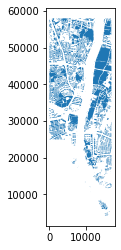

In [47]:
import os

with open("./temp.json",'w',encoding='utf-8') as json_file:
        json.dump(pixeldata,json_file,ensure_ascii=False)
        
pData = gpd.read_file('temp.json')

geoData=pData.drop(['id'],axis=1)

geoData.crs =None

geoData.plot()

os.remove('temp.json')

## 图像切割并调整point

In [48]:
def createBoxRegion(box):
    boxpoly = gpd.GeoSeries([Polygon([(box[0],box[1]), (box[2],box[1]), (box[2],box[3]), (box[0],box[3])])])
    boxdf = gpd.GeoDataFrame({'geometry': boxpoly, 'box':[1]})
    return boxdf

In [49]:
val_num = 50
imgShape

(58012, 17038, 3)

In [52]:

from shapely.geometry import Polygon
output_DIR = './../../datasets/segBuildings/'

segShape =(2000,2000)
imgShape = mat.shape

os.makedirs(output_DIR+'/val/', exist_ok=True)
os.makedirs(output_DIR+'/train/', exist_ok=True)

rowStep = 5000
colStep = 5000

for row in range(0,imgShape[0],rowStep):
    for col in range(0,imgShape[1],colStep):
        
        rowEnd = row + segShape[0] if row + 2*segShape[0] < imgShape[0] else imgShape[0] 
        colEnd = col + segShape[1] if col + 2*segShape[1] < imgShape[1] else imgShape[1]
        
        if colEnd <col + segShape[1]:
            continue
        if rowEnd <row + segShape[0]:
            continue
            
        pic=mat[row:rowEnd,col:colEnd,:]
                
        boxdf = createBoxRegion((col,row,colEnd,rowEnd))

        try:
            mask=gpd.overlay(boxdf, geoData, how='intersection',keep_geom_type=True)
        
        except Exception as e:   
            continue
        
        mask=mask.translate(-col,-row)        
        
        if len(mask) > 0:
            saveName = '/train/'+tif_id+str(row)+'_'+str(col)+'_'+str(rowEnd)+'_'+str(colEnd)
            mask.to_file(output_DIR+saveName+'.json', driver='GeoJSON', encoding="utf-8")
            io.imsave(output_DIR+saveName+'.jpg',pic)



In [11]:
pic=mat[22000:24000,10000:12000,:]

boxdf = createBoxRegion((10000,22000,12000,24000))

mask=gpd.overlay(boxdf, geoData, how='intersection',keep_geom_type=True)
# mask=mask.translate(-10000,-10000)       


<AxesSubplot:>

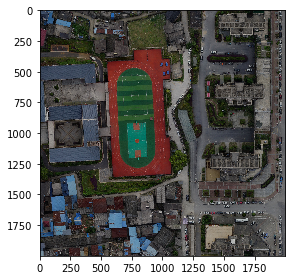

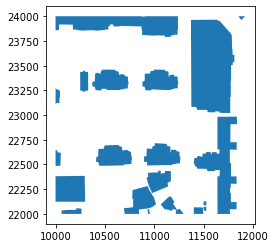

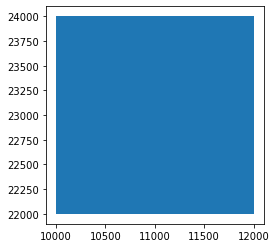

In [12]:
io.imshow(pic)
mask.plot(aspect=1)
boxdf.plot()

In [17]:
import exifread
tif_path="/home/zhizizhang/Documents/gisdata/JingDeZhen13.tif"

In [18]:
with open(tif_path, 'rb') as f:
    tags = exifread.process_file(f)
    print(tags.keys())

dict_keys(['Image ImageWidth', 'Image ImageLength', 'Image BitsPerSample', 'Image Compression', 'Image PhotometricInterpretation', 'Image StripOffsets', 'Image SamplesPerPixel', 'Image RowsPerStrip', 'Image StripByteCounts', 'Image PlanarConfiguration', 'Image SampleFormat', 'Image Tag 0x87AF', 'Image Tag 0x87B1', 'Image Tag 0xA480'])


In [19]:

tags

{'Image ImageWidth': (0x0100) Short=17038 @ 2965573872,
 'Image ImageLength': (0x0101) Short=58012 @ 2965573884,
 'Image BitsPerSample': (0x0102) Short=[8, 8, 8] @ 2965574060,
 'Image Compression': (0x0103) Short=Uncompressed @ 2965573908,
 'Image PhotometricInterpretation': (0x0106) Short=2 @ 2965573920,
 'Image StripOffsets': (0x0111) Long=[] @ 2965806114,
 'Image SamplesPerPixel': (0x0115) Short=3 @ 2965573944,
 'Image RowsPerStrip': (0x0116) Short=1 @ 2965573956,
 'Image StripByteCounts': (0x0117) Long=[] @ 2965574066,
 'Image PlanarConfiguration': (0x011C) Short=1 @ 2965573980,
 'Image SampleFormat': (0x0153) Short=UnsignedUnsignedUnsigned @ 2966038162,
 'Image Tag 0x87AF': (0x87AF) Short=[1, 1, 0, 7, 1024, 0, 1, 2, 1025, 0, 1, 1, 2048, 0, 1, 4326, 2049, 34737, 7, 0, 2054, 0, 1, 9102, 2057, 34736, 1, 1, 2059, 34736, 1, 0] @ 2966038296,
 'Image Tag 0x87B1': (0x87B1) ASCII=WGS 84| @ 2966038376,
 'Image Tag 0xA480': (0xA480) ASCII=<GDALMetadata>
   <I, ... ] @ 2966038384}

In [53]:
print(tags['Image Tag 0x87AF'].values[0:8])
print(tags['Image Tag 0x87AF'].values[8:16])
print(tags['Image Tag 0x87AF'].values[16:24])
print(tags['Image Tag 0x87AF'].values[24:32])




[1, 1, 0, 7, 1024, 0, 1, 2]
[1025, 0, 1, 1, 2048, 0, 1, 4326]
[2049, 34737, 7, 0, 2054, 0, 1, 9102]
[2057, 34736, 1, 1, 2059, 34736, 1, 0]


{'Image ImageWidth': (0x0100) Short=17038 @ 2965573872,
 'Image ImageLength': (0x0101) Short=58012 @ 2965573884,
 'Image BitsPerSample': (0x0102) Short=[8, 8, 8] @ 2965574060,
 'Image Compression': (0x0103) Short=Uncompressed @ 2965573908,
 'Image PhotometricInterpretation': (0x0106) Short=2 @ 2965573920,
 'Image StripOffsets': (0x0111) Long=[] @ 2965806114,
 'Image SamplesPerPixel': (0x0115) Short=3 @ 2965573944,
 'Image RowsPerStrip': (0x0116) Short=1 @ 2965573956,
 'Image StripByteCounts': (0x0117) Long=[] @ 2965574066,
 'Image PlanarConfiguration': (0x011C) Short=1 @ 2965573980,
 'Image SampleFormat': (0x0153) Short=UnsignedUnsignedUnsigned @ 2966038162,
 'Image Tag 0x87AF': (0x87AF) Short=[1, 1, 0, 7, 1024, 0, 1, 2, 1025, 0, 1, 1, 2048, 0, 1, 4326, 2049, 34737, 7, 0, 2054, 0, 1, 9102, 2057, 34736, 1, 1, 2059, 34736, 1, 0] @ 2966038296,
 'Image Tag 0x87B1': (0x87B1) ASCII=WGS 84| @ 2966038376,
 'Image Tag 0xA480': (0xA480) ASCII=<GDALMetadata>
   <I, ... ] @ 2966038384}

In [34]:
# 117.1851654052734375,29.2826922710019559 : 117.2028048147170125,29.3350582122802734

In [56]:
# <1> UTC时间，hhmmss（时分秒）格式
# <2> 定位状态，A=有效定位，V=无效定位
# <3> 纬度ddmm.mmmm（度分）格式（前面的0也将被传输）
# <4> 纬度半球N（北半球）或S（南半球）
# <5> 经度dddmm.mmmm（度分）格式（前面的0也将被传输）
# <6> 经度半球E（东经）或W（西经）
# <7> 地面速率（000.0~999.9节，前面的0也将被传输）
# <8> 地面航向（000.0~359.9度，以真北为参考基准，前面的0也将被传输）
# <9> UTC日期，ddmmyy（日月年）格式
# <10> 磁偏角（000.0~180.0度，前面的0也将被传输）
# <11> 磁偏角方向，E（东）或W（西）
# <12> 模式指示（仅NMEA0183 3.00版本输出，A=自主定位，D=差分，E=估算，N=数据无效）